# Трёхмерная графика

В этой задаче вам надо отрисовать следующее изображение:

![Результат](qRu1HKi.png)
<!--![Результат](https://imgur.com/yU07iGV.png)-->

Вам предстоит работать с векторами в трёхмерном пространстве. В данной задаче считается, что каждый такой вектор с координатами `x`, `y`, `z` задаётся как `v = np.array([x,y,z])`. Предполагается, что это координаты в некотором фиксированном правом ортонормированном базисе. Каждая точка отождествляется с соответствующим радиус-вектором. Над векторами можно выполнять следующие операции: вычислять длину `np.linalg.norm(v)`, умножать вектор на число `c*v` (здесь `c` — это число),  складывать векторы `v+u` (здесь `u` — это другой вектор), вычитать `v-u`, вычислять скалярное произведение `np.dot(u, v)` и вычислять векторное произведение `np.cross(u, v)`. **В учебных целях в данной задаче вам запрещено  напрямую обращаться к координатам `v[0], v[1], v[2]`**; при этом гарантируется, что все подзадачи можно решить, применяя только вышеперечисленные операции над векторами, арифметические операции и элементарные средства языка python.

*Важное замечание:* по техническим причинам для сравнения дробных чисел `x` (например, `x = np.dot(u,v)`, `x = np.linalg.norm(v)` и т.п.) с нулём вместо `x==0` пишите `abs(x)<1e-9`. Это может показаться  абсурдным, но практически во всех популярных языках (python, C, C++, C#, Java...) нужно следовать этому правилу, чтобы не допустить очень трудноуловимых багов. По этой же причине вместо `x==y` пишут `abs(x-y)<1e-9`.

**1. Луч и плоскость.** Допишите следующую функцию. На вход даны векторы `u`, `r`, `p`, `p1`, `p2`, такие что `r` не равен нулю, а `p1` и `p2` не коллинеарны. Векторы `u` и `r` задают открытый луч `u+t*r`, где `t>0` (обратите внимание, что `t=0` не учитывается). Верните -1, если луч не пересекает плоскость, заданную уравнением `p+a*p1+b*p2`, где  `a` и `b` суть действительные числа, и верните `t>0`, такое что `u+t*r` лежит в этой плоскости в противном случае.

In [9]:
def ray_plane_intersection(u, r, p, p1, p2):
    '''Вернуть t>0, такое что u+t*r лежит в плоскости p+a*p1+b*p2, либо -1'''
    normal_p1p2 = np.cross(p1, p2)
    scalar = np.dot(normal_p1p2, r)

    if np.isclose(scalar, 0):
        return -1

    t = np.dot(normal_p1p2, (p-u)) / scalar

    if t > 0:
        return t
    return -1

**2. Натянутое изображение.** Допишите следующую функцию. На вход вам дано изображение `image` размера `w`  на `h` и три вектора `x`, `p1` и `p2`. Каждый пиксель изображения (`image[i,j]`, где `0<=i<w` и `0<=j<h`) — это число от 0 до 255, задающее градацию серого от чёрного до белого. Гарантируется, что `p1` и `p2` не равны нули и ортогональны. Изображение `image`  «натянуто» на  прямоугольник с вершинами `0`, `p1`, `p2`, `p1+p2`, как на рисунке:

![Натянутое image](Kbr7RME.png)

Верните -1, если вектор `x` не лежит в этом прямоугольнике, и верните соответствующий пиксель  изображения `image` в противном случае.

In [10]:
from math import *
def get_pixel(image, x, p1, p2):
    '''Пиксель, соответствующий x в изображении, натянутом на p1 и p2, либо -1'''

    w, h = image.shape
    normal = np.cross(p1, p2)

    if np.dot(x, normal) > 1e-9:
        return -1

    matrix = np.column_stack((p1, p2, normal))

    try:
        a, b, c = np.linalg.solve(matrix, x)
    except np.linalg.LinAlgError:
        return -1

    if -1e-9 <= a < 1 and -1e-9 <= b < 1 and -1e-9 <= c <= 1:
        i = floor(a * w)
        j = floor(b * h)
        return image[i, j]
    else:
        return -1

**3. Простое 3D.** Идея генерации трёхмерного изображения следующая. В пространстве выбирается *экран* — прямоугольник с вершинами `q`, `q+q1`, `q+q2`, `q+q1+q2`, где `q1` и `q2` — ортогональные векторы. На некотором расстоянии от центра экрана (примерно `max(|q1|,|q2|)/2`) выбирается точка — *камера*. Пусть разрешение картинки — `w` пикселей в ширину и `h` в высоту.  Экран разбивается на `w * h` равных прямоугольников, соответствующих пикселям. Из камеры в центр каждого такого прямоугольника пускается луч. Цвет соответствующего пикселя равен цвету объекта, в который данный луч врезается (для простоты считайте, что между камерой и экраном нет объектов); либо равен 0 (чёрный цвет), если луч уходит в пустоту.

![Трассировка лучей](dplKzvv.png)

В данной задаче все объекты представляют собой прямоугольники, хранящиеся в списке `ractangles`. Каждый прямоугольник `rect=rectangles[k]` (где `0<=k<len(rectangles)`) задан тремя векторами `p=rect[0]`, `p1=rect[1]`, `p2=rect[2]` и чёрно-белым изображением `image=rect[3]`, такими что `p1` и `p2` ортогональны, вершины прямоугольника — это `p`, `p+p1`, `p+p2`, `p+p1+p2`, а `image` «натянуто» на прямоугольник аналогично тому, как это делалось в подзадаче 2.

Алгоритм генерации трёхмерной картинки выглядит следующим образом (не меняйте этот код!):

In [11]:
def generate_scene(camera, q, q1, q2, w, h, rectangles):
    '''Генерация 3D сцены в прямоугольнике с вершинами q, q+q1, q+q2, q+q1+q2'''
    result = np.zeros(shape = [w, h])
    for i in range(w):
        for j in range(h):
            pixel = q + q1 * ((i + 0.5) / w) + q2 * ((j + 0.5) / h)
            ray = pixel - camera
            result[i, j] = trace_ray(camera, ray, rectangles)
    return result

Пользуясь решениями предыдущих подзадач, вам нужно дописать функцию `trace_ray`, которая определяет цвет луча `camera + t*ray` (где `t>0`):

In [12]:
def trace_ray(camera, ray, rectangles):
    '''Цвет пикселя, в который врезается луч, либо 0, если он уходит в никуда'''
    closest_t = float('inf')
    color = 0

    for rect in rectangles:
        p, p1, p2, image = rect[0], rect[1], rect[2], rect[3]
        t = ray_plane_intersection(camera, ray, p, p1, p2)

        if t > 0 and t < closest_t:
            intersection_point = camera + t * ray
            pixel_color = get_pixel(image, intersection_point - p, p1, p2)

            if pixel_color != -1:
                closest_t = t
                color = pixel_color

    return color

**4. Свет.** Картинка выглядит не очень эффектно без света. Чтобы это исправить, задают *источник света* — точку `light`. Пусть данный луч `camera+t*ray` врезается в точку `r` объекта `rectangles[k]`, имеющую цвет `c`. Если камера смотрит на неосвещённую сторону объекта, то итоговый пиксель равен `c*0.1` (затемнённый `c`). Если на освещённую, то яркость зависит от угла падения света: падающий вскользь свет слабее. А именно, итоговый пиксель равен `c*0.1 + c*0.9*`$|\cos\alpha|$, где $\alpha$ — это угол между вектором `light-r` и нормалью, `n`, опущенной из точки `r` объекта:

![Трассировка лучей](MhBEALK.png)

Опираясь на решение предыдущей подзадачи, допишите функцию `trace_ray_light`, которая учитывает световые эффекты.


In [13]:
def trace_ray_light(camera, ray, rectangles, light):
    '''Цвет пикселя, в который врезается луч, либо 0, если он уходит в никуда'''
    result = 0
    closest_t = float('inf')

    for rect in rectangles:
        p, p1, p2, image = rect[0], rect[1], rect[2], rect[3]

        matrix = np.column_stack((ray, -p1, -p2)).astype(float)

        try:
            t, a, b = np.linalg.solve(matrix, (p - camera).astype(float))

            if t > 0 and -1e-9 <= a <= 1 + 1e-9 and -1e-9 <= b <= 1 + 1e-9:
                w, h = image.shape
                i = min(max(int(a * (w - 1)), 0), w - 1)
                j = min(max(int(b * (h - 1)), 0), h - 1)

                if t < closest_t:
                    closest_t = t
                    c = image[i, j]

                    n = np.cross(p1, p2).astype(float)
                    light_direction = light - (camera + t * ray)

                    n /= np.linalg.norm(n)
                    light_direction /= np.linalg.norm(light_direction)

                    light_orientation = np.linalg.det([light - p, p1, p2])
                    camera_orientation = np.linalg.det([camera - p, p1, p2])

                    cos_alpha = np.dot(light_direction, n)
                    if cos_alpha < 0:
                        cos_alpha = abs(cos_alpha)

                    if (light_orientation > 0) == (camera_orientation > 0):
                        result = c * 0.1 + c * 0.9 * cos_alpha
                    else:
                        result = c * 0.1

        except np.linalg.LinAlgError:
            continue

    return result

**5. Отражения.** В рамках данной задачи некоторые объекты могут быть полузеркальными. А именно, каждый `rect=rectangle[k]` содержит дополнительное поле `rect[4]`, равное `True`, если объект полузеркальный, и `False` в противном случае. Пусть луч, выпущенный из камеры, сталкивается с объектом `rect` в точке `r`. Предположим, что объект полузеркальный (неполузеркальные обрабатываются так же, как в предыдущей подзадаче). Тогда луч отражается по закону  «угол падения равен углу отражения». Цвет отражённого луча вычисляется обычным способом с учётом световых эффектов, как если бы он был выпущен из камеры, находящейся в точке `r`; обозначим этот вычисленный цвет через `a`. Пусть `b` —  это «истинный» цвет `rect` в точке `r`, полученный из изображения `image=rect[3]` без учёта света. Тогда цвет точки `r` равен `c=0.3*a+b*0.7` и затем уже к `c` применяются световые преобразования, т.е. итоговый пиксель равен `c*0.1`, если точка не освещена, и `c*0.1+c*0.9*`$|\cos\alpha|$, если освещена, где $\alpha$ — это определённый выше угол.

Для выполнения задания вам понадобится функция `reflect`, которая находит отражение вектора `x` относительно вектора `n`, т.е. находит `y`, такой что `x` и `y` имеют равную длину, равный угол с `n` и лежат в одной плоскости:

![Отражение](VYJR1DG.png)

Допишите функцию `reflect` и затем, пользуясь ею и опираясь на решение предыдущей подзадачи, функцию `trace_ray_full`, которая учитывает свет и полузеркальные объекты.

In [17]:
def reflect(x, n):
    return -x + 2 * (np.dot(x, n) / np.dot(n, n)) * n

def trace_ray_full(camera, ray, rectangles, light, depth=5):
    '''Цвет пикселя, в который врезается луч, либо 0, если он уходит в никуда'''
    if depth <= 0:
        return 0

    result = 0
    closest_t = float('inf')

    for rect in rectangles:
        p, p1, p2, image, reflected = rect[0], rect[1], rect[2], rect[3], rect[4]
        matrix = np.column_stack((ray, -p1, -p2)).astype(float)

        try:
            t, a, b = np.linalg.solve(matrix, (p - camera).astype(float))

            if t > 0 and -1e-9 <= a <= 1 + 1e-9 and -1e-9 <= b <= 1 + 1e-9:
                w, h = image.shape
                i = min(max(int(a * (w - 1)), 0), w - 1)
                j = min(max(int(b * (h - 1)), 0), h - 1)

                if t < closest_t:
                    closest_t = t
                    c = image[i, j]

                    n = np.cross(p1, p2).astype(float)
                    intersection_point = camera + t * ray
                    n /= np.linalg.norm(n)

                    if reflected:
                        reflected_ray = reflect(ray, n)
                        reflected_color = trace_ray_full(intersection_point, reflected_ray, rectangles, light, depth - 1)
                        base_color = c
                        color = 0.3 * reflected_color + 0.7 * base_color
                    else:
                        color = c

                    light_direction = light - intersection_point
                    light_direction /= np.linalg.norm(light_direction)

                    light_orientation = np.linalg.det([light - p, p1, p2])
                    camera_orientation = np.linalg.det([camera - p, p1, p2])

                    cos_alpha = np.dot(light_direction, n)
                    if cos_alpha < 0:
                        cos_alpha = abs(cos_alpha)

                    if (light_orientation > 0) == (camera_orientation > 0):
                        result = color * 0.1 + color * 0.9 * cos_alpha
                    else:
                        result = color * 0.1

        except np.linalg.LinAlgError:
            continue

    return result

## Тестирование

Осталось проверить, проходят ли ваши решения первоначальное тестирование. Выполните весь код (Cell -> Run All или Runtime -> Run All или другим способом, работающим в вашей среде) и посмотрите вердикт внизу страницы. В тестирующем коде разбираться не нужно! Для подзадач 3, 4 и 5 нет тестов как таковых; для проверки сравнивайте сгенерированное изображение с картинкой, приведённой в самом начале (но ваша картинка будет иметь меньшее разрешение и связанные с подзадачей отличия: отсутствие освещения или полузеркальных объектов).


In [15]:
#%load https://pastebin.com/raw/86zTjYhx
try:
    import numpy as np, matplotlib.pyplot as plt, imageio
except ImportError:
    !pip3 install imageio matplotlib
    import numpy as np, matplotlib.pyplot as plt, imageio
%matplotlib inline

def test_all():
    ray_plane_intersection_tests = [
      (2**0.5 / 2, [np.array([-1,1,-123]), np.array([2**0.5 / 2, 2**0.5 / 2,0]),
            np.array([0,1,0]), np.array([1,-1,0]), np.array([0,0,1])]),
      (-1, [np.array([1,0,33]), np.array([1,1,1]),
            np.array([0,1,0]), np.array([1,-1,0]), np.array([0,0,1])]),
      (-1, [np.array([0,0,0]), np.array([-2,2,0]),
            np.array([0,1,0]), np.array([1,-1,0]), np.array([0,0,1])]),
    ]
    succ = True
    for test in ray_plane_intersection_tests:
        ans = ray_plane_intersection(*test[1])
        if abs(test[0] - ans) >= 1e-8:
            print('Первое задание не прошло тест:')
            print('Результат', ans, 'должен быть', test[0], 'на параметрах', test[1])
            succ = False
            break
    if succ:
        print('Первое задание прошло все тесты')

    get_pixel_tests = [
      (12, [np.array([[11,12], [21,22]]),
            np.array([-3,2,0]), np.array([1,2,0]), np.array([-4,2,0])]),
      (-1, [np.array([[11,12], [21,22]]),
            np.array([-3,2,0.002]), np.array([1,2,0]), np.array([-4,2,0])]),
      (32, [np.array([[11,12], [21,22], [31,32], [41,42]]),
            np.array([-2,3,0]), np.array([-4,2,0]), np.array([1,2,0])]),
      (-1, [np.array([[11,12], [21,22], [31,32], [41,42]]),
            np.array([-2,4,0]), np.array([-4,2,0]), np.array([1,2,0])]),
    ]
    succ = True
    for test in get_pixel_tests:
        ans = get_pixel(*test[1])
        if abs(test[0] - ans) >= 1e-8:
            print('Второе задание не прошло тест:')
            print('Результат', ans, 'должно быть', test[0], 'на параметрах', test[1])
            succ = False
            break
    if succ:
        print('Второе задание прошло все тесты')

    reflect_tests = [
      (np.array([5/3,2,7/3]), [ np.array([5/3,2,7/3]), np.array([5,6,7]) ]),
      (np.array([-3,-1,0]), [ np.array([-1,-3,0]), np.array([2,2,0]) ]),
      (np.array([0,0,0]), [ np.array([0,0,0]), np.array([2,0,0]) ]),
    ]
    for test in reflect_tests:
        ans = reflect(*test[1])
        if abs(np.linalg.norm(test[0] - ans)) >= 1e-8:
            print('Пятое задание не прошло тест:')
            print('Результат', ans, 'должно быть', test[0], 'на параметрах', test[1])
            break

Первое задание прошло все тесты
Второе задание прошло все тесты


<ipython-input-18-6b6b96a7ce4a>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  wall = imageio.imread('/content/lFweyPE.png', pilmode='L')
<ipython-input-18-6b6b96a7ce4a>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  logo = imageio.imread('/content/CHPOlZD.png', pilmode='L').T


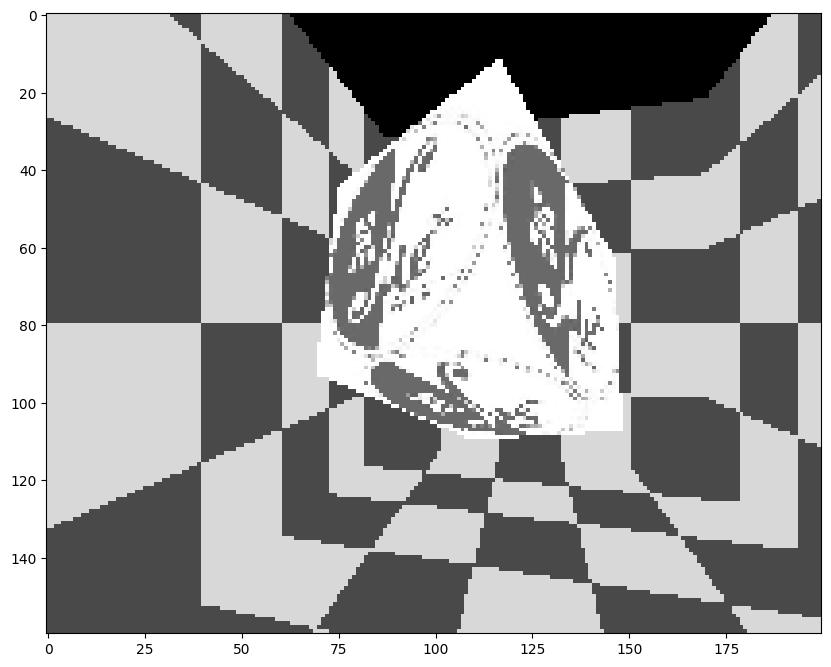

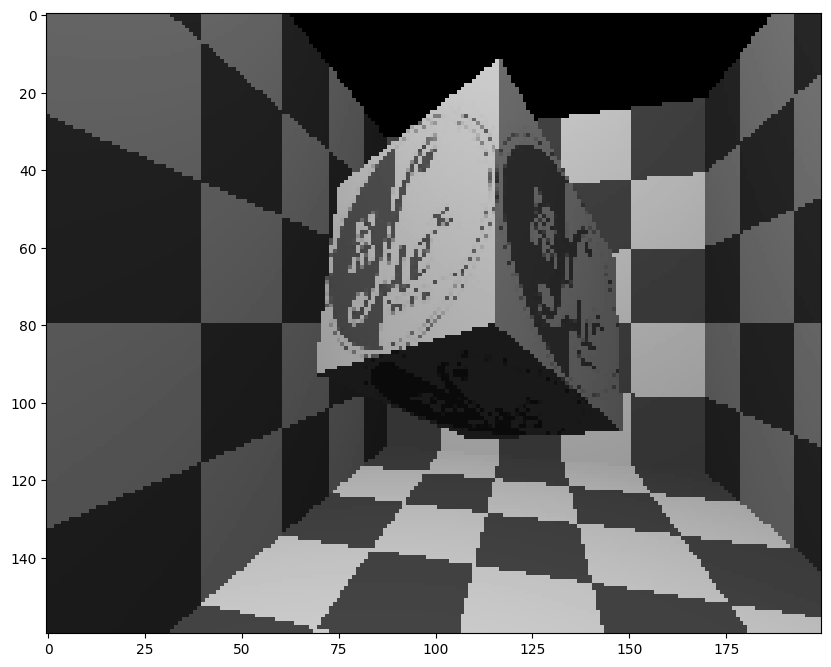

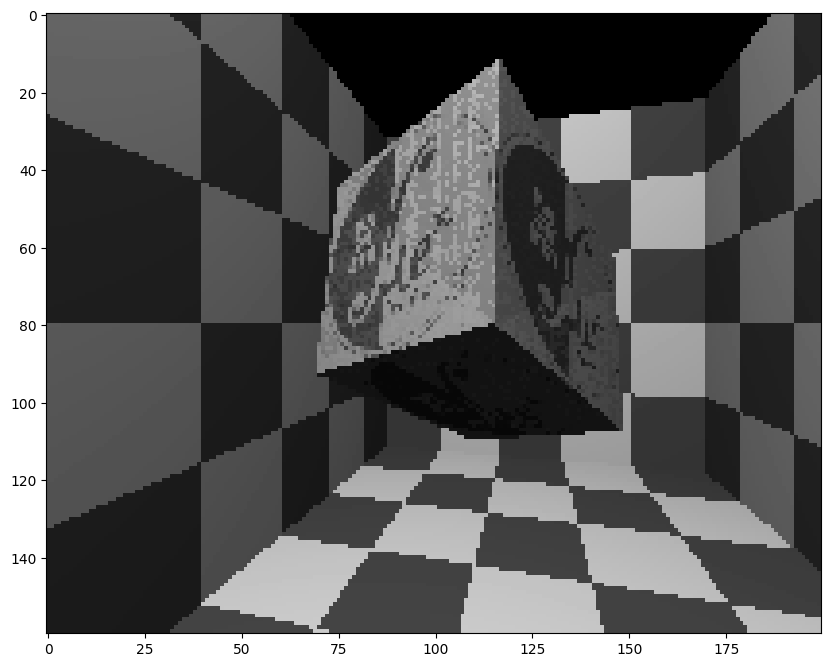

In [18]:
  def generate_light_scene(camera, q, q1, q2, w, h, rectangles, light, rtrace):
    result = np.zeros(shape = [w, h])
    for i in range(w):
        for j in range(h):
            pixel = q + q1 * ((i + 0.5) / w) + q2 * ((j + 0.5) / h)
            ray = pixel - camera
            result[i, j] = rtrace(camera, ray, rectangles, light)
    return result

def render(w, h):
    wall = imageio.imread('/content/lFweyPE.png', pilmode='L')
    logo = imageio.imread('/content/CHPOlZD.png', pilmode='L').T
    #logo = imageio.imread('https://imgur.com/1ToSif6.png', pilmode='L').T
    camera = np.array([-30, -30, 0])
    q, q1, q2 = np.array([-50, 50, 30]), np.array([100, -60, 0]), np.array([0, 0, -60])
    light = np.array([-40, -20, 150])
    rects = [
        [np.array([-50, 50, -40]), np.array([100, 100, 0]), np.array([0, 0, 100]), wall, False],
        [np.array([-50, 50, -40]), np.array([100, 100, 0]), np.array([100, -100, 0]), wall, False],
        [np.array([50, -50, -40]), np.array([100, 100, 0]), np.array([0, 0, 100]), wall, False],
        [np.array([50, 150, -40]), np.array([100, -100, 0]), np.array([0, 0, 100]), wall, False],
        [np.array([10, 100, 30]), np.array([20, -60, 10]), np.array([-10, -10, -40]), logo, True],
        [np.array([30, 40, 40]), np.array([75, 21, -24]), np.array([-10, -10, -40]), logo, True],
        [np.array([0, 90, -10]), np.array([20, -60, 10]), np.array([75, 21, -24]), logo, True]
    ]

    scene = generate_scene(camera, q, q1, q2, w, h, rects)
    plt.figure(figsize=[10,10])
    plt.imshow(scene.T, cmap='gray', vmin=0, vmax=255)
    scene = generate_light_scene(camera, q, q1, q2, w, h, rects, light, trace_ray_light)
    plt.figure(figsize=[10,10])
    plt.imshow(scene.T, cmap='gray', vmin=0, vmax=255)
    scene = generate_light_scene(camera, q, q1, q2, w, h, rects, light, trace_ray_full)
    plt.figure(figsize=[10,10])
    plt.imshow(scene.T, cmap='gray', vmin=0, vmax=255)

test_all()
render(w = 200, h = 160) #Можно повысить разрешение, но ждать придётся дольше